# Genetic algorithm

اینجا کتابخانه های موردنظر و هایپرپارامتر ها رو تعریف می کنیم

n= طول جایگشت

first_population=تعداد اولیه جمعیت

pm=احتمال جهش

pc=احتمال بازترکیب

p_rep=درصد اینکه چقدر از فرزندان تولید شده جایگزین والد ها شوند

و میانگین و کوواریانس رو تعریف میکنیم

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
n=10
first_population=300
tournament=3
pm=50
pc=90
p_rep=0.1
beta=100
choose_per=10
mean =list(pd.read_csv("expected_return.csv").values)
cov = list(pd.read_csv("covariance_matrix.csv").values)

در این تابع ما تعداد جمعیت اولیه و اندازه هر جایگشت را به تابع میدهیم و تابع به اندازه تعداد جمعیت اولیه مقدار اولیه رندوم تولید میکنیم و در یک لیست ذخیره می کنیم

In [2]:
def generate_first_population(n,first_num):
    first_population=[]
    for i in range(first_num):
        permutation=np.random.randint(100,size=n)
        permutation=permutation/ sum(permutation)
        first_population.append(list(permutation))
    return first_population

در این تابع ما برازش را برای یک جایگشت یا کروموزوم محاسبه میکنیم. از فرمول
x.T C x - B mean.T x
محاسبه میکنیم که بتا را با توجه به اهمیت سود تعیین میکنیم که هرچه این تابع کمتر باشه بهتره

In [3]:
def fitness_of_chromosome(n,chromosome,mean,cov,beta):
    mean=[mean]
    mean=np.array(mean)
    chromosome_t=[chromosome]
    c_t=np.array(chromosome_t)
    c=c_t.transpose()
    tmp=np.matmul(cov,c)
    fit=np.matmul(c_t,tmp)
    fit=fit-(beta*np.matmul(mean,c))
    return float(fit)

این تابع کل جایگشت ها را میگیرد و برازش تک تک جایگشت ها را محاسبه میکند و در یک لیست ذخیره میکند

In [4]:
def fitness_of_all(n,permutation,first_population,mean,cov,beta):
    fitness=[0 for i in range(first_population)]
    for i in range(first_population):
        fitness[i]=fitness_of_chromosome(n,permutation[i],mean,cov,beta)
    return fitness

با استفاده از انتخاب مسابقه ای که پویش و انتفاع مناسبی دارد 3 تا جایگشت را به صورت رندوم انتخاب میکنیم و اون جایگشتی که دارای بهترین برازش است به عنوان والد برمیگردانیم

معمولا دو والد میخواهیم پس این تابع را دوبار صدا میزنیم

In [5]:
def tournament_select(fitness,first_population,tournament):
    candidate=[0 for i in range(tournament)]
    for i in range(tournament):
        candidate[i]=random.randint(0,first_population-1)
    best=candidate[0]
    for i in range(1,tournament):
        if(fitness[candidate[i]]<fitness[best]):
            best=candidate[i]
    return best

در این تابع برای بازترکیب از روش بازترکیب ترتیبی استفاده میکنیم

In [6]:
def order_recombination(chrom1,chrom2,n):
    child1=[0 for i in range(n)]
    first_index=0
    second_index=0
    while(second_index-first_index<=4):
        first_index=random.randint(0,n-1)
        second_index=random.randint(0,n-1) 
    for i in range(first_index,second_index):
        child1[i]=chrom1[i]
    x=second_index
    while(x%n!=first_index):
        child1[x%n]=chrom2[x%n]
        x+=1
    tmp=sum(child1)
    if(tmp!=1):
        child1=child1/(tmp)
    return list(child1)

چون جایگشت ها وزیر هستند و یک به یک تداخل دارند روش جهش جابه جایی روش مناسبی هست و در تولید جایگشت های متنوع و بهتر کمک میکند و جایگشت را نیز خیلی تغییر نمیدهد

In [7]:
def swap_mutation(orders,n,choose_per):
    chance=random.randint(0,100)
    new_orders = orders.copy()
    if(chance<choose_per):
        i=random.randint(0, len(orders) - 1)
        j=random.randint(0, len(orders) - 1)
        while(i==j):
            i = random.randint(0, len(orders) - 1)
            j = random.randint(0, len(orders) - 1)

        temp = new_orders[i]
        new_orders[i] = new_orders[j]
        new_orders[j] = temp
    else:
        count=random.choices([1,2,3,4,5],weights=[15,30,40,20,10],k=1)
        for i in range(count[0]):
            j=random.randint(0, len(orders) - 1)
            new_orders[j]=random.uniform(0.0,1.0)
        tmpsum=sum(new_orders)
        if(tmpsum!=1):
            new_orders=new_orders/tmpsum
    return new_orders

کوچکترین مقدار برازش را برمیگرداند

In [8]:
def find_best_fitness(fitness,first_population):
    index=0
    best=fitness[index]
    for i in range(first_population):
        if(fitness[i]<best):
            index=i
            best=fitness[index]
    return (index,best)

ما میدانیم که دو لیست جایگشت ها و مقدار برازش متناظر با یکدیگرند پس تابع زیر روی لیست برازش حرکت میکند و براساس مقادیر برازش لیست را مرتب میکند و ما همزمان همان جابه جایی ها را در لیست جایگشت ها اعمال میکنیم

In [9]:
def sort_base_on_fitness(permutation,fitness,first_population):
    for i in range(0,first_population-1):
        min_in=i
        for j in range(i+1,first_population):
            if(fitness[j]<fitness[min_in]):
                min_in=j
        tmp1=fitness[min_in]
        fitness[min_in]=fitness[i]
        fitness[i]=tmp1
        tmp2=permutation[min_in].copy()
        permutation[min_in]=permutation[i].copy()
        permutation[i]=tmp2.copy()
    return (permutation,fitness)

این بدنه اصلی برنامه است ابتدا جمعیت اولیه را میسازیم و لیست برازش آن را محاسبه میکنیم و بهترین جایگشت با کمترین برازش را انتخاب میکنیم

حال وارد حلقه میشویم:

در یک فور ابتدا دو والد را با انتخاب مسابقه ای انتخاب میکنیم بعد یک عدد رندوم تولید میکنیم برای اینکه اگه از 90 کمتر بود دو تا بچه تولید میکنیم و باز همینکار را برای دو فرزند ولی اینبار به قصد جهش انجام میدهیم

حال اگر بالای 90 بود حهش را روی دو والد انجام میدهیم و به لیست بجه ها اضافشون میکنیم

حال برازش را برای کودکان محاسبه میکنیم

حال جمعیت اولیه و لیست کودکان را بر اساس برازش مرتب میکنیم

حال 90 درصد جمعیت جدید را از لیست جمعیت اولیه (والدها) انتخاب میکنیم و بقیه آن را از لیست کودکان

حال بهترین جایگشت با کمترین برازش را انتخاب میکنیم و اگر با بهترین سابق یکی بود کاندیشن را یکی زیاد میکنیم بدین معنی که الگوریتم ما بهترین مقدار جدیدی را تولید نکرده و اگر 250 بار تولید نکند خارج میشویم

و همین روند را تکرار میکنیم

بقیه هایپر پارامتر ها را به صورت تجربی باید بیابیم

In [10]:
start=time.time()

#in this part we made the initial permutations
finall_permutation = generate_first_population(n,first_population)
finall_fitness=fitness_of_all(n,finall_permutation,first_population,mean,cov,beta)
best_index,best_fitness=find_best_fitness(finall_fitness,first_population)
all_of_resaults=[]

condition=0

#in this while we reapeat making children and And we take 90% of the population
#from the best parents and the rest from the children in each iteration
while(True):
    child_permutation=[0 for i in range(first_population)]
    x=0
    for i in range(first_population//2):
        parent1=tournament_select(finall_fitness,first_population,tournament)
        parent2=tournament_select(finall_fitness,first_population,tournament)
        
        percentage=random.randint(0,100)
        if(percentage<pc):
            
            child_permutation[x]=order_recombination(finall_permutation[parent1],finall_permutation[parent2],n)
            child_permutation[x+1]=order_recombination(finall_permutation[parent2],finall_permutation[parent1],n)
            
            percentage2=random.randint(0,100)
            if(percentage<pm):
                
                child_permutation[x]=swap_mutation(child_permutation[x],n,choose_per)
                child_permutation[x+1]=swap_mutation(child_permutation[x+1],n,choose_per)
                
            x+=2
        else:
            child_permutation[x]=swap_mutation(finall_permutation[parent1],n,choose_per)
            child_permutation[x+1]=swap_mutation(finall_permutation[parent2],n,choose_per)
            x+=2
    child_fitness=fitness_of_all(n,child_permutation,first_population,mean,cov,beta)
    
    
    finall_permutation,finall_fitness=sort_base_on_fitness(finall_permutation,finall_fitness,first_population)
    
    child_permutation,child_fitness=sort_base_on_fitness(child_permutation,child_fitness,first_population)
    
    parentcount=(int)(first_population*p_rep)
    
    j=0
    #here we concatinate the parents and childrens and make the population
    for i in range(parentcount,first_population):
        finall_permutation[i]=child_permutation[j]
        finall_fitness[i]=child_fitness[j]
    
    finall_permutation,finall_fitness=sort_base_on_fitness(finall_permutation,finall_fitness,first_population)
    tmp_index,tmp_fitness=find_best_fitness(finall_fitness,first_population)
    #this if/else is for our algorithm to exit the loop 
    #if its best answer does not change after,for example, 250 times
    if(tmp_fitness==best_fitness):
        condition+=1
    else:
        condition=0
    best_fitness=tmp_fitness
    best_index=tmp_index
    all_of_resaults.append(best_fitness)
    #this print is here just to see the process of the algorithm
    print(best_fitness,end='\r')
    if(condition>=250):
        break
print('\nbest fitness: ',best_fitness,' \nbest index: ',best_index,'\narray: ',finall_permutation[best_index])
print('\n\n', find_best_fitness(finall_fitness,first_population))
end=time.time()
seconds=end-start
hours=(int)(seconds//3600)
seconds=seconds-(hours*3600)
minutes=(int)(seconds//60)
seconds=seconds-(minutes*60)
print('Time: ', hours,' hours ',minutes,' minutes ',seconds,'seconds')

-1.9107315435840947
best fitness:  -1.910731543584094  
best index:  0 
array:  [0.00016796128205908646, 0.0001563745378483172, 4.1902832024785074e-05, 8.011001499521903e-05, 3.505496215758697e-05, 5.550353331790287e-05, 0.00015637453784831718, 0.9991347540048677, 0.00013006374611960274, 4.190054876150491e-05]


 (0, -1.910731543584094)
Time:  0  hours  1  minutes  32.226157903671265 seconds


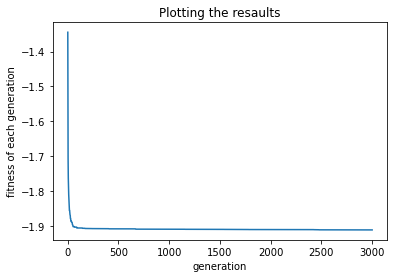

In [11]:
arr=all_of_resaults
ite = [i+1 for i in range(len(arr))]
plt.plot(ite, arr)
plt.ylabel('fitness of each generation') #set the label for y axis
plt.xlabel('generation') #set the label for x-axis
plt.title("Plotting the resaults") #set the title of the graph
plt.show() #display the graph

In [13]:
chromosome=finall_permutation[best_index].copy()
mean=[mean]
mean=np.array(mean)
chromosome_t=[chromosome]
c_t=np.array(chromosome_t)
c=c_t.transpose()
tmp=np.matmul(cov,c)
fit=np.matmul(c_t,tmp)
print(fit)
fit=np.matmul(mean,c)
print(fit)

[[0.01015555]]
[[[[0.01920887]]]]
